In [1]:
from os.path import join
import time
import numpy as np
import scipy.sparse as sp
import pandas as pd
import geopandas as gpd
import networkx as nx
import contextily as cx
from sklearn.metrics import normalized_mutual_info_score as nmi
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import jaccard_score
from spatial_graphs import SpatialGraph, SpatialDiGraph
from collections import Counter

import matplotlib.pyplot as plt

datadir = join("..", "data", "matrices")
resultsdir = join("..", "data", "port_results")
imdir = join("..", "images", "port")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

save_ims = True
date = time.strftime("%d-%m-%y")

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# utility functions
def add_legend(cols, ax):
    legend_graph = SpatialGraph()
    N = len(set(cols))
    for ix in range(N):
        legend_graph.add_node(ix)
    leg_cols = [cmap(x) for x in range(N)]
    leg_coords = {x: (-200, np.linspace(10, 80, N)[x]) for x in range(N)}
    leg_dict = {x: f"group {y}" for x, y in zip(range(N), range(N))}

    # DIY legend
    pos_shift = {}
    x_off = 15
    y_off = 0 
    for k, v in leg_coords.items():
        pos_shift[k] = (v[0]+x_off, v[1]+y_off)
        
    nx.draw_networkx_nodes(legend_graph, pos=leg_coords, ax=ax, node_color=leg_cols, node_size=1000)
    nx.draw_networkx_labels(legend_graph, pos=pos_shift, ax=ax, labels=leg_dict)

# Classic Modularity Results 
## (needs to be updated for new file structures)
These results are calculated from a clean install of Python-Louvain. <br>
Modularity applied to symmetrised port network. <br>
The trade partition is the partition where edge weights include capacity and the flow partition is based on flow data only

In [3]:
datadir = join("..", "data", "matrices")

dmat = np.load(join(datadir, "port_dmat.npy"))
fmat = sp.load_npz(join(datadir, "cargo_ports.npz")).toarray()
tmat = sp.load_npz(join(datadir, "cargo_ports_trade.npz")).toarray()
N, _ = fmat.shape

# load the coords
coords_df = pd.read_csv(join(datadir, "coords.csv"), index_col=0)
id_df = pd.read_csv(join(datadir, "id_key.csv"))
id_df.columns = ["id", "port"]
port_ids = {key: port for key, port in zip(id_df.id, id_df.port)}
rport_ids = {port: key for key, port in zip(id_df.id, id_df.port)}

coords = [(x, y) for x, y in zip(coords_df.x, coords_df.y)]
coords = {port: coord for port, coord in zip(coords_df.port_country, coords)}

ports_list = [port for port in rport_ids.keys()]  # list of ports in use
coords_new = {}
for port in ports_list:
    coords_new[rport_ids[port]] = coords[port]
    
g = SpatialGraph.from_numpy_array(fmat, dists=dmat)
gt = SpatialGraph.from_numpy_array(tmat, dists=dmat)

g_dir = SpatialDiGraph.from_numpy_array(fmat, dists=dmat)
gt_dir = SpatialDiGraph.from_numpy_array(fmat, dists=dmat)

FileNotFoundError: [Errno 2] No such file or directory: '../data/matrices/port_dmat.npy'

In [2]:
# process partitions
res = 1
flow_partition = pd.read_csv(join(resultsdir, f"classic_partition_res{res}.csv"), index_col=[0])
trade_partition = pd.read_csv(join(resultsdir, f"classic_partition_trade_res{res}.csv"), index_col=[0])

# deal with singleton communities
s = flow_partition.community.value_counts() == 1
singletons_flow = [*filter(s.get, s.index)]
s = trade_partition.community.value_counts() == 1
singletons_trade = [*filter(s.get, s.index)]

flow_partition.community = flow_partition.community.apply(lambda x: -1 if x in singletons_flow else x)
trade_partition.community = trade_partition.community.apply(lambda x: -1 if x in singletons_trade else x)

flow_partition = flow_partition.sort_values(by=['community', 'degree'], ascending=[True, False])
trade_partition = trade_partition.sort_values(by=['community', 'degree'], ascending=[True, False])

Nf = len(set(flow_partition.community))
Nt = len(set(trade_partition.community))

fmod_indices = [x for x in Counter(flow_partition.community).values()]
fmod_indices = [sum(fmod_indices[:x]) for x in range(Nf)]

tmod_indices = [x for x in Counter(trade_partition.community).values()]
tmod_indices = [sum(tmod_indices[:x]) for x in range(Nt)]

# sort into groups by mod and degree
fmod_order = [x for x in flow_partition.sort_values(by=['community', 'degree'], ascending=[True, False]).index]
tmod_order = [x for x in trade_partition.sort_values(by=['community', 'degree'], ascending=[True, False]).index]

fpartition_names = {port_ids[node]: group for node, group in zip(flow_partition.index, flow_partition)}
tpartition_names = {port_ids[node]: group for node, group in zip(trade_partition.index, trade_partition)}



NameError: name 'pd' is not defined

In [3]:
# some tests
for i in range(len(tmod_order)-1):
    ix = tmod_order[i]
    ix_1 = tmod_order[i+1]
    assert trade_partition.community[ix] <= trade_partition.community[ix_1]
    
for i in range(len(fmod_order)-1):
    ix = fmod_order[i]
    ix_1 = fmod_order[i+1]
    assert flow_partition.community[ix] <= flow_partition.community[ix_1]

NameError: name 'tmod_order' is not defined

In [75]:
# change from dfs to dicts
flow_partition = {node: com for node, com in zip(flow_partition.index, flow_partition.community)}
trade_partition = {node: com for node, com in zip(trade_partition.index, trade_partition.community)}

# Colormaps
Create a nice colormap that allows up to ~6 different categories (any more is too much to visualise anyway)

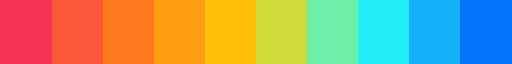

In [76]:
# https://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels-using-matplotlib
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
# https://towardsdatascience.com/creating-colormaps-in-matplotlib-4d4de78a04b8
# http://seaborn.pydata.org/tutorial/color_palettes.html
# https://blog.datawrapper.de/beautifulcolors/ - good for distinct colours in hex
# https://blog.datawrapper.de/colorguide/#Copy-from-the-masters
# https://www.color-hex.com/color-palettes/
# http://vrl.cs.brown.edu/color
# https://coolors.co/001219-005f73-0a9396-94d2bd-e9d8a6-ee9b00-ca6702-bb3e03-ae2012-9b2226
cols = ["#0373fc", "#26fff8", "#ffd105", "#ff8214", "#f73455"][::-1]
cmap = LinearSegmentedColormap.from_list(
    'partition colours', cols, Nf)
cols = [cmap(val) for val in flow_partition.values()]
cmap



# Flow network results
To copy Xu et al., do adjacency matrix in mod groups and sort by degree within groups

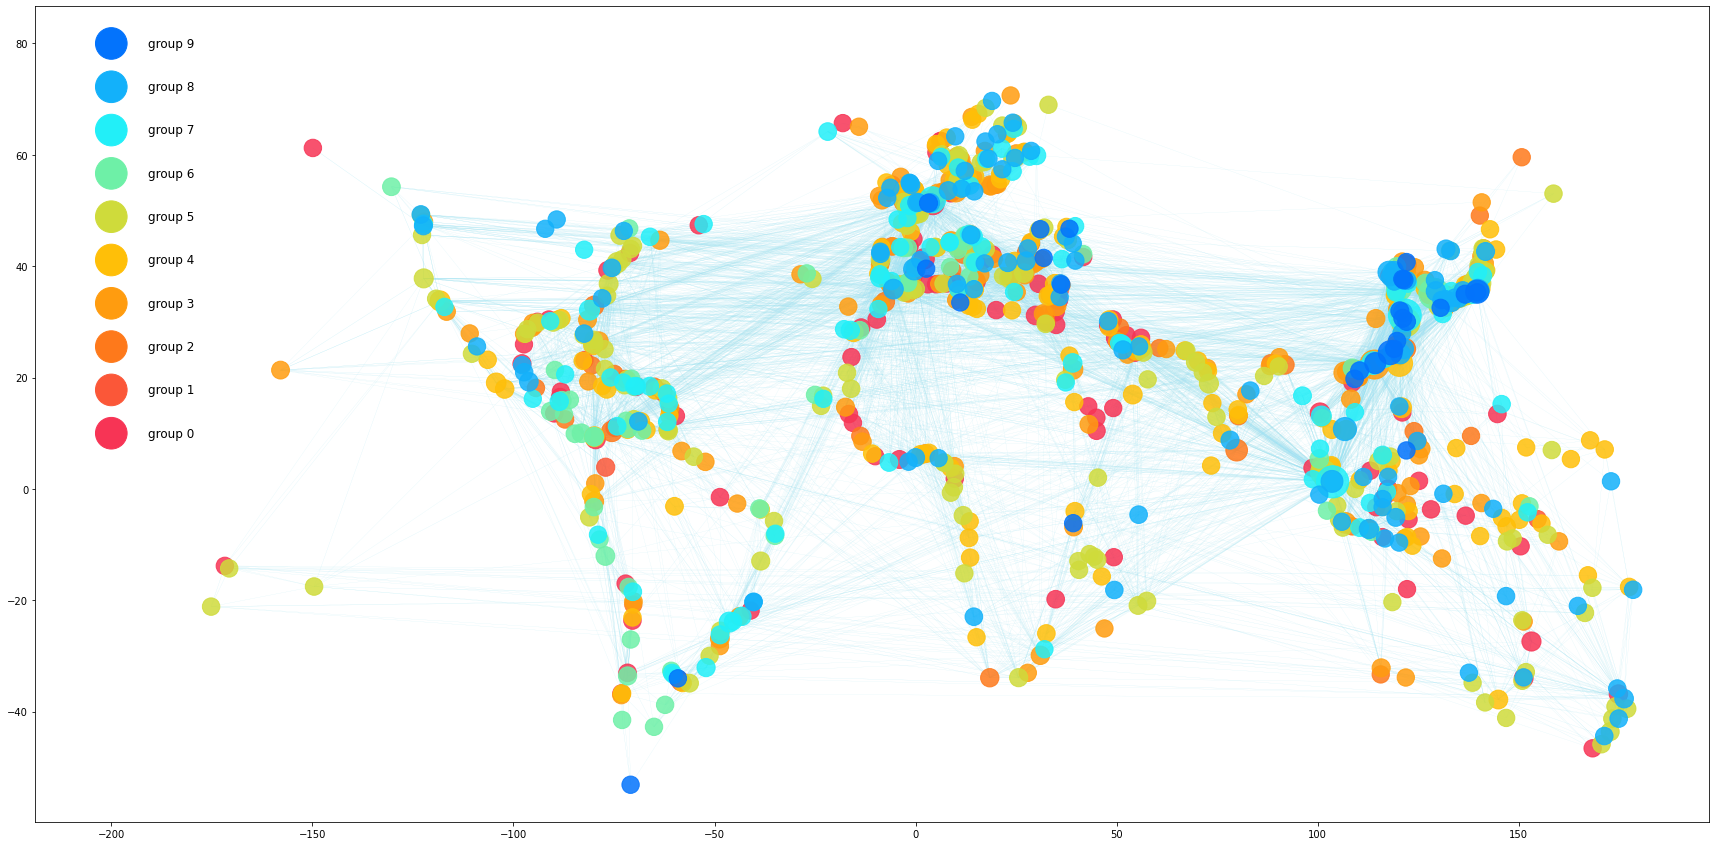

In [77]:
fig, ax = plt.subplots(figsize=(30, 15))
add_legend(cols, ax)
g.draw_spatial(coords=coords_new, edge_col='#9de3f2', ax=ax, cols=cols, node_add=300, node_mag=0.05, edge_mag=0.001,figsize=(25, 10))

if save_ims:
    fig.savefig(join(imdir, f"classic_flow_mod_{res}.png" ))

## Need to fix this

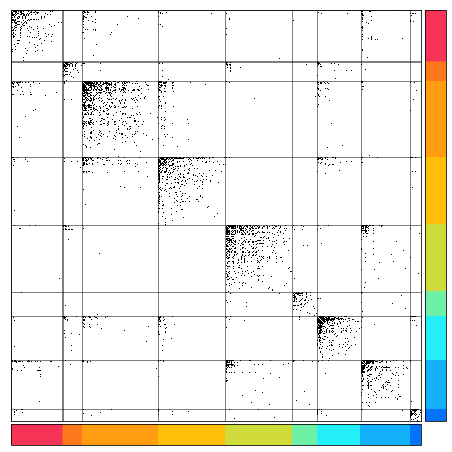

In [78]:

# colours = [x for x in set(cols)]
bins = fmod_indices.copy()
bins.append(950)

norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=cmap.N)

fig, ax = plt.subplots(1, figsize=(8, 8))
im = ax.spy(nx.linalg.adjacency_matrix(g, nodelist=fmod_order).toarray())
ax.set_xticks([])
ax.set_yticks([])
for ix in range(Nf):
    ax.axhline(y=fmod_indices[ix], color='k', linewidth=0.5)
    ax.axvline(x=fmod_indices[ix], color='k', linewidth=0.5)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cb1 = mpl.colorbar.ColorbarBase(cax1,
                                cmap=cmap,
                                norm=norm,
                                ticks=[],
                                spacing='proportional',
                                orientation='horizontal')

cb2 = mpl.colorbar.ColorbarBase(cax2,
                                cmap=cmap,
                                norm=norm,
                                ticks=[],
                                spacing='proportional',
                                orientation='vertical')
cb2.ax.invert_yaxis() 

if save_ims:
    fig.savefig(join(imdir, f"adj_flow_mod_ordered_{res}.png" ))

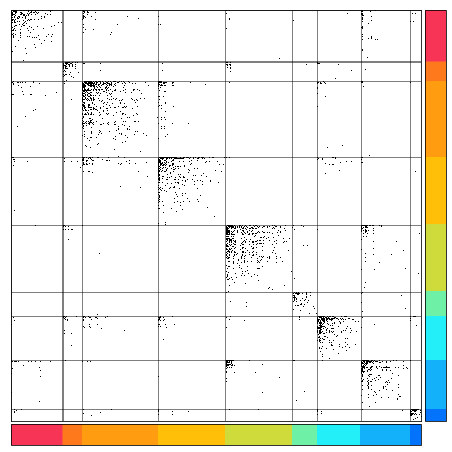

In [79]:
# now look at directed graph

colours = [x for x in set(cols)]
bins = fmod_indices.copy()
bins.append(950)

norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=cmap.N)

fig, ax = plt.subplots(1, figsize=(8, 8))
im = ax.spy(nx.linalg.adjacency_matrix(g_dir, nodelist=fmod_order).toarray())
ax.set_xticks([])
ax.set_yticks([])
for ix in range(Nf):
    ax.axhline(y=fmod_indices[ix], color='k', linewidth=0.5)
    ax.axvline(x=fmod_indices[ix], color='k', linewidth=0.5)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cb1 = mpl.colorbar.ColorbarBase(cax1,
                                cmap=cmap,
                                norm=norm,
                                ticks=[],
                                spacing='proportional',
                                orientation='horizontal')

cb2 = mpl.colorbar.ColorbarBase(cax2,
                                cmap=cmap,
                                norm=norm,
                                ticks=[],
                                spacing='proportional',
                                orientation='vertical')
cb2.ax.invert_yaxis() 

if save_ims:
    fig.savefig(join(imdir, f"adj_dir_flow_mod_ordered_{res}.png" ))

# Trade intensity network results

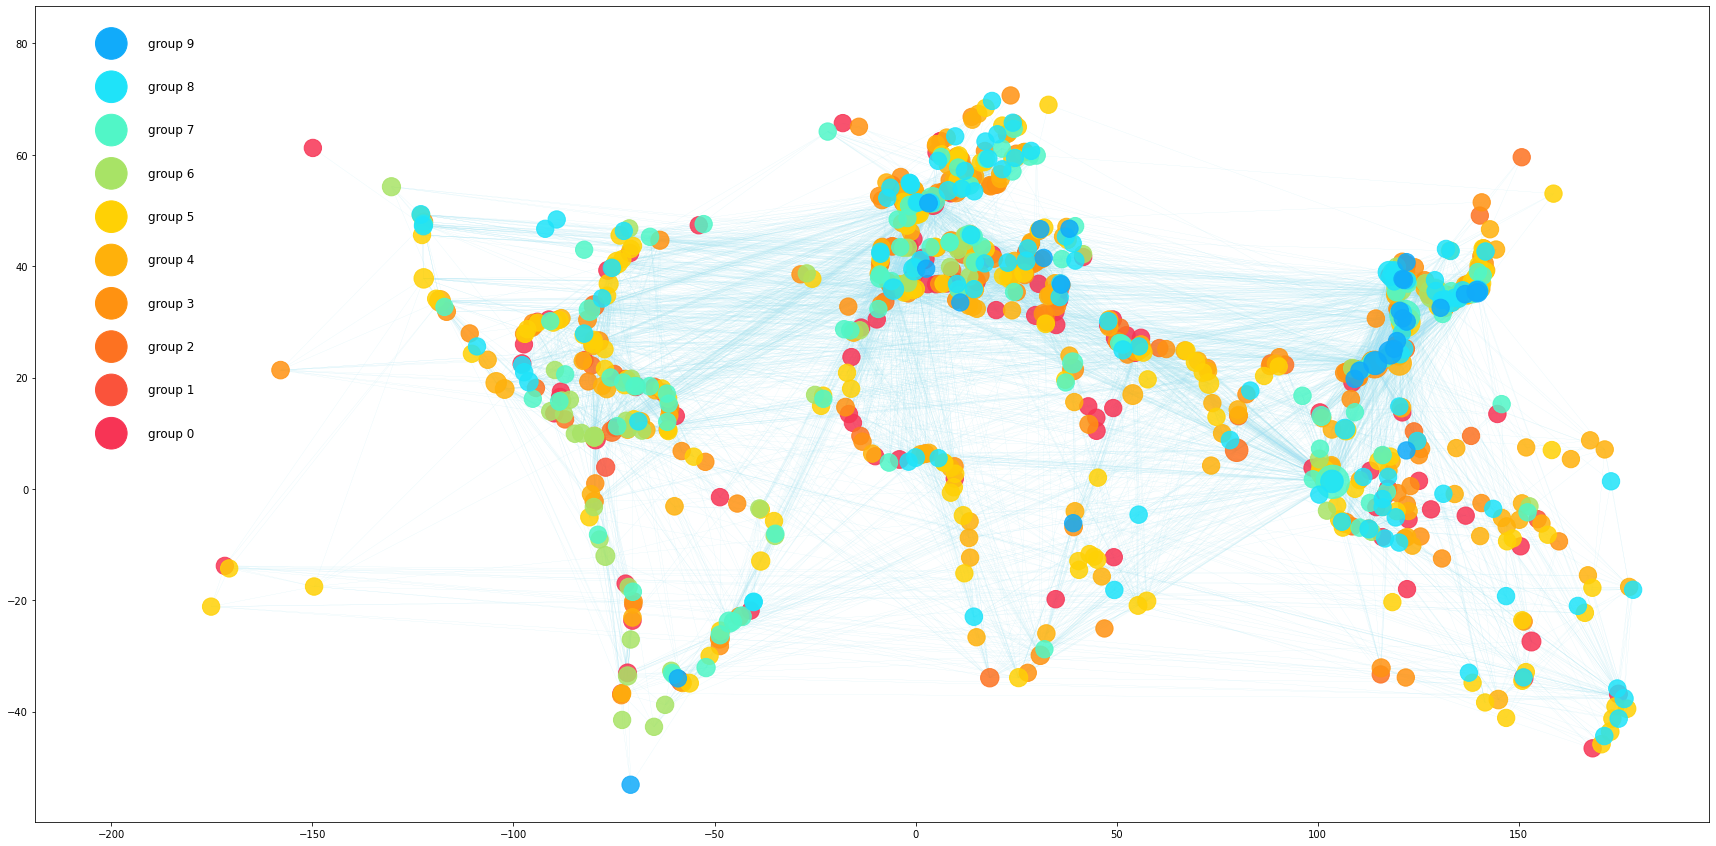

In [80]:
Nt = len(set(trade_partition.values()))

cols = ["#0373fc", "#26fff8", "#ffd105", "#ff8214", "#f73455"][::-1]
cmap = LinearSegmentedColormap.from_list(
    'partition colours', cols, Nt)
cols = [cmap(val) for val in flow_partition.values()]
#cmap = plt.cm.cool
#cmaplist = [cmap(i) for i in range(cmap.N)]
#cmap = LinearSegmentedColormap.from_list(
#    'partition colours', cmaplist, Nt)
#cols = [cmap(val) for val in trade_partition.values()]

fig, ax = plt.subplots(figsize=(30,15))
add_legend(cols, ax)
gt.draw_spatial(coords=coords_new, ax=ax, cols=cols, edge_col='#9de3f2', node_add=300, node_mag=1e-6,edge_mag=1e-10,figsize=(25, 10))

if save_ims:
    fig.savefig(join(imdir, f"classic_trade_mod_{res}.png" ))

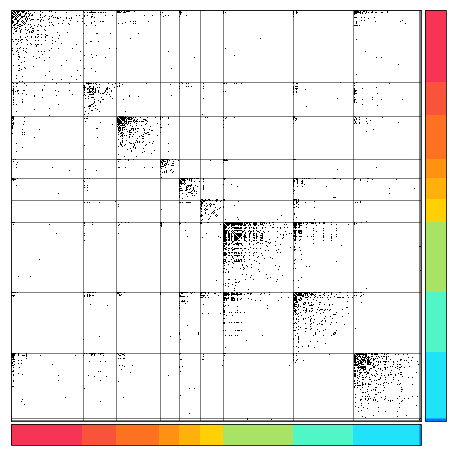

In [81]:
colours = [x for x in set(cols)]
bins = tmod_indices.copy()
bins.append(950)

norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=cmap.N)

fig, ax = plt.subplots(1, figsize=(8, 8))
im = ax.spy(nx.linalg.adjacency_matrix(gt, nodelist=tmod_order).toarray())
ax.set_xticks([])
ax.set_yticks([])
for ix in range(Nt):
    ax.axhline(y=tmod_indices[ix], color='k', linewidth=0.5)
    ax.axvline(x=tmod_indices[ix], color='k', linewidth=0.5)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cb1 = mpl.colorbar.ColorbarBase(cax1,
                                cmap=cmap,
                                norm=norm,
                                ticks=[],
                                spacing='proportional',
                                orientation='horizontal')

cb2 = mpl.colorbar.ColorbarBase(cax2,
                                cmap=cmap,
                                norm=norm,
                                ticks=[],
                                spacing='proportional',
                                orientation='vertical')
cb2.ax.invert_yaxis() 

if save_ims:
    fig.savefig(join(imdir, f"adj_trade_mod_ordered_{res}.png" ))

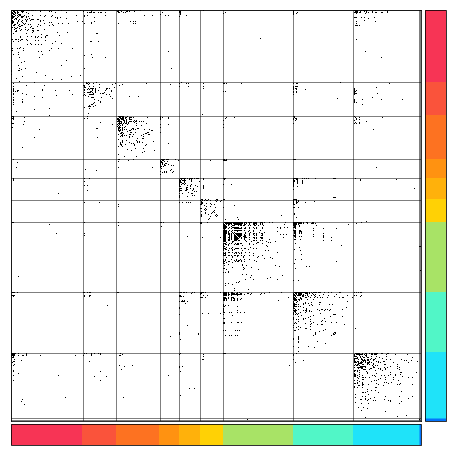

In [82]:
bins = tmod_indices.copy()
bins.append(950)

norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=cmap.N)

fig, ax = plt.subplots(1, figsize=(8, 8))
im = ax.spy(nx.linalg.adjacency_matrix(gt_dir, nodelist=tmod_order).toarray())
ax.set_xticks([])
ax.set_yticks([])
for ix in range(Nt):
    ax.axhline(y=tmod_indices[ix], color='k', linewidth=0.5)
    ax.axvline(x=tmod_indices[ix], color='k', linewidth=0.5)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cb1 = mpl.colorbar.ColorbarBase(cax1,
                                cmap=cmap,
                                norm=norm,
                                ticks=[],
                                spacing='proportional',
                                orientation='horizontal')

cb2 = mpl.colorbar.ColorbarBase(cax2,
                                cmap=cmap,
                                norm=norm,
                                ticks=[],
                                spacing='proportional',
                                orientation='vertical')
cb2.ax.invert_yaxis() 

if save_ims:
    fig.savefig(join(imdir, f"adj_dir_trade_mod_ordered_{res}.png" ))